### Praktische Anwendung von DoubleML auf die Lalonde-Dehejia-Wahba-Daten  mit männlichen Teilnehmern

In [ ]:
# Notwendige Bibliotheken importieren
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression, LogisticRegressionCV
from doubleml import DoubleMLIRM, DoubleMLData
from doubleml.utils.resampling import DoubleMLResampling
from sklearn.model_selection import cross_val_predict
import matplotlib.pyplot as plt
import seaborn as sns
import sys, os
# hier den Pfad zur Funktion pscore_discard aus functions.py einfügen
sys.path.append(os.path.abspath("."))
from functions import pscore_discard
from matplotlib.patches import Patch
from matplotlib.lines import Line2D
import warnings
warnings.filterwarnings("ignore")


In [ ]:
# Lalonde-Dehejia-Wahba-Daten einlesen - Quelle: https://users.nber.org/~rdehejia/data/.nswdata2.html
ldw_tr = pd.read_csv("Code/Lalonde/Daten/nswre74_treated.txt", sep='\\s+', header=None)  #185
ldw_co = pd.read_csv("Code/Lalonde/Daten/nswre74_control.txt", sep='\\s+', header=None)  #260
spaltenname = ['treat', 'age', 'education', 'black', 'hispanic', 'married', 'nodegree', 're74', 're75', 're78']
ldw_tr.columns = spaltenname
ldw_co.columns = spaltenname
# Arbeitslosenstatus für die Jahre 1974 und 1975 hinzufügen
ldw_tr['u74'] = np.where(ldw_tr['re74'] == 0, 1, 0)
ldw_tr['u75'] = np.where(ldw_tr['re75'] == 0, 1, 0)
ldw_co['u74'] = np.where(ldw_co['re74'] == 0, 1, 0)
ldw_co['u75'] = np.where(ldw_co['re75'] == 0, 1, 0)
# Daten zusammenführen
ldw = pd.concat([ldw_tr, ldw_co]).reset_index(drop=True) #445

In [ ]:
# nicht-experimentelle Vergleichsgruppen aus CPS- und PSID-Daten einlesen 
cps_co = pd.read_csv("Code/Lalonde/Daten/cps_controls.txt", sep='\\s+', header=None)  #15992
psid_co = pd.read_csv("Code/Lalonde/Daten/psid_controls.txt", sep='\\s+', header=None)  #2490
spaltenname = ['treat', 'age', 'education', 'black', 'hispanic', 'married', 'nodegree', 're74', 're75', 're78']
cps_co.columns = spaltenname
psid_co.columns = spaltenname
# Arbeitslosenstatus für die Jahre 1974 und 1975 hinzufügen
cps_co['u74'] = np.where(cps_co['re74'] == 0, 1, 0)
cps_co['u75'] = np.where(cps_co['re75'] == 0, 1, 0)
psid_co['u74'] = np.where(psid_co['re74'] == 0, 1, 0)
psid_co['u75'] = np.where(psid_co['re75'] == 0, 1, 0)

In [ ]:
# Lalonde-Dehejia-Wahba-CPS-Daten zusammenführen
ldw_cps = pd.concat([ldw_tr, cps_co]).reset_index(drop=True)
# Lalonde-Dehejia-Wahba-PSID Daten-zusammenführen
ldw_psid = pd.concat([ldw_tr, psid_co]).reset_index(drop=True)

### Lalonde-Dehejia-Wahba Datensatz

### Verteilungen der Kovariaten

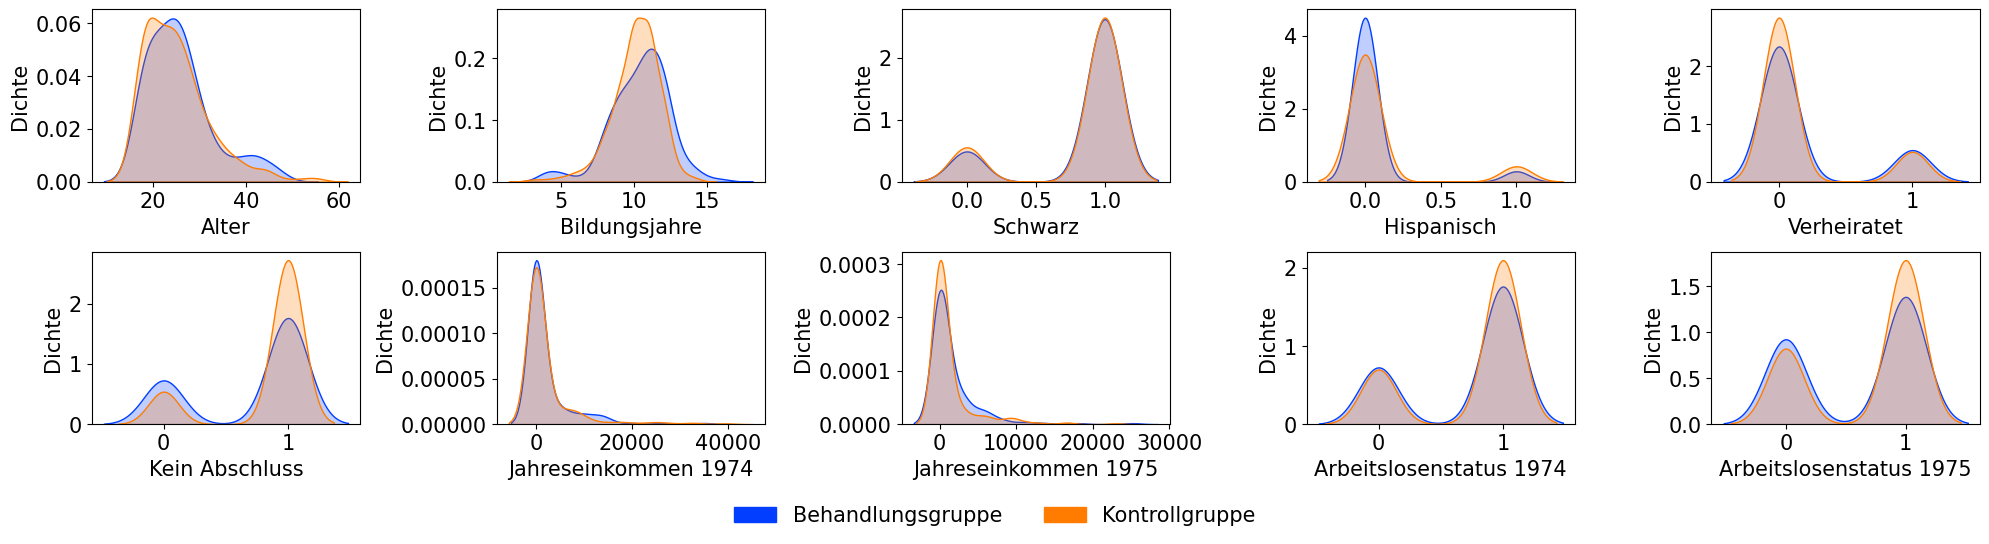

In [5]:
# Kovariaten und Behandlungsvariable extrahieren
ldw_d = ldw.treat
ldw_X = ldw[["age", "education", "black", "hispanic", "married", "nodegree", "re74", "re75", "u74", "u75"]]

# Subplots erstellen
fig, axs = plt.subplots(2, 5, figsize=(20, 5))
axs = axs.flatten() 

# Farben aus der 'bright'-Palette extrahieren
colors = sns.color_palette('bright')

# Dichteverteilung der Kovariaten in den LDW-CPS-Daten plotten
for i, covariate in enumerate(ldw_X.columns):
    sns.kdeplot(ldw[ldw['treat'] == 1][covariate], ax=axs[i], fill=True, color=colors[0],  legend=False)
    sns.kdeplot(ldw[ldw['treat'] == 0][covariate], ax=axs[i], fill=True, color=colors[1],  legend=False)
    # Schriftgröße der Achsenwerte anpassen
    axs[i].tick_params(axis='both', labelsize=15)
    axs[i].set_ylabel('Dichte', fontsize=15)
    # Beschriftungen der X-Achse umbenennen
    if i == 0:
        axs[i].set_xlabel('Alter', fontsize=15)
    if i == 1:
        axs[i].set_xlabel('Bildungsjahre', fontsize=15)
    if i == 2:
        axs[i].set_xlabel('Schwarz', fontsize=15)     
    if i == 3:
        axs[i].set_xlabel('Hispanisch', fontsize=15)   
    if i == 4:
        axs[i].set_xlabel('Verheiratet', fontsize=15)
    if i == 5:
        axs[i].set_xlabel('Kein Abschluss', fontsize=15)
    if i == 6:
        axs[i].set_xlabel('Jahreseinkommen 1974', fontsize=15)
    if i == 7:
        axs[i].set_xlabel('Jahreseinkommen 1975', fontsize=15)
    if i == 8:
        axs[i].set_xlabel('Arbeitslosenstatus 1974', fontsize=15)
    if i == 9:
        axs[i].set_xlabel('Arbeitslosenstatus 1975', fontsize=15)

# Manuelle Legende erstellen
handles = [
    Patch(color=colors[0], label='Behandlungsgruppe'),
    Patch(color=colors[1], label='Kontrollgruppe')] 

# Legende korrekt platzieren
fig.legend(handles=handles, loc='lower center', fontsize=15, bbox_to_anchor=(0.5, -0.1), ncols=2, frameon=False)

# Layout anpassen
plt.tight_layout()
plt.show()

In [6]:
# Mittelwerte der Kovariaten in den beiden Gruppen berechnen
ldw.groupby(['treat']).mean()

,age,education,black,hispanic,married,nodegree,re74,re75,re78,u74,u75
treat,,,,,,,,,,,
0.0,25.053846,10.088462,0.826923,0.107692,0.153846,0.834615,2107.026658,1266.909002,4554.801126,0.750000,0.684615
1.0,25.816216,10.345946,0.843243,0.059459,0.189189,0.708108,2095.573689,1532.055314,6349.143530,0.708108,0.600000


In [7]:
# LDW-Benchmark berechnen
ldw_benchmark = ldw.groupby(['treat']).mean()['re78'][1] - ldw.groupby(['treat']).mean()['re78'][0]
ldw_benchmark

1794.342404270269

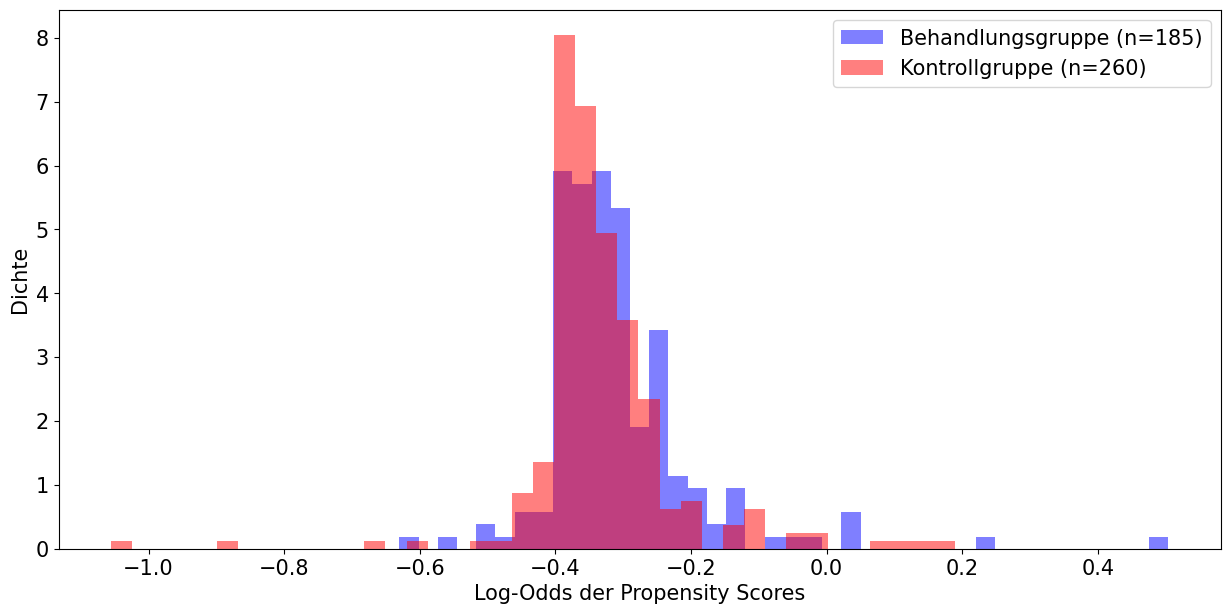

In [8]:
# Seed für die Reproduzierbarkeit festlegen
np.random.seed(1234)

# Propensity Scores mittels logistischer Regression mit Kreuzvalidierung schätzen
logistic_model = LogisticRegressionCV()
logistic_model.fit(X=ldw_X, y=ldw_d)
ldw['ps_lr'] = logistic_model.predict_proba(ldw_X)[:, 1]
# Log-Odds der Propensity Scores berechnen
ldw['log_odds_ps_lr'] = np.log(ldw['ps_lr'] / (1 - ldw['ps_lr']))
# Anazahl der behandelten und unbehandelten Beobachtungen berechnen
count_treated = ldw.loc[ldw['treat'] == 1].shape[0]
count_untreated = ldw.loc[ldw['treat'] == 0].shape[0]

# Dichteverteilung der Log-Odds der Propensity Scores in den Lalonde-Dehejia-Wahba-Daten plotten
plt.figure(figsize=(15, 7))
plt.hist(ldw[ldw['treat'] == 1]['log_odds_ps_lr'], bins=40, alpha=0.5, color='blue', label=f'Behandlungsgruppe (n={count_treated})', density=True)
plt.hist(ldw[ldw['treat'] == 0]['log_odds_ps_lr'], bins=40, alpha=0.5, color='red', label=f'Kontrollgruppe (n={count_untreated})', density=True)
plt.xlabel('Log-Odds der Propensity Scores', fontsize=15)
plt.ylabel('Dichte', fontsize=15)
plt.tick_params(axis='both', labelsize=15)
plt.legend(fontsize=15)
plt.show()

### Lalonde-Dehejia-Wahba-CPS-Daten: Verteilungen der Kovariaten

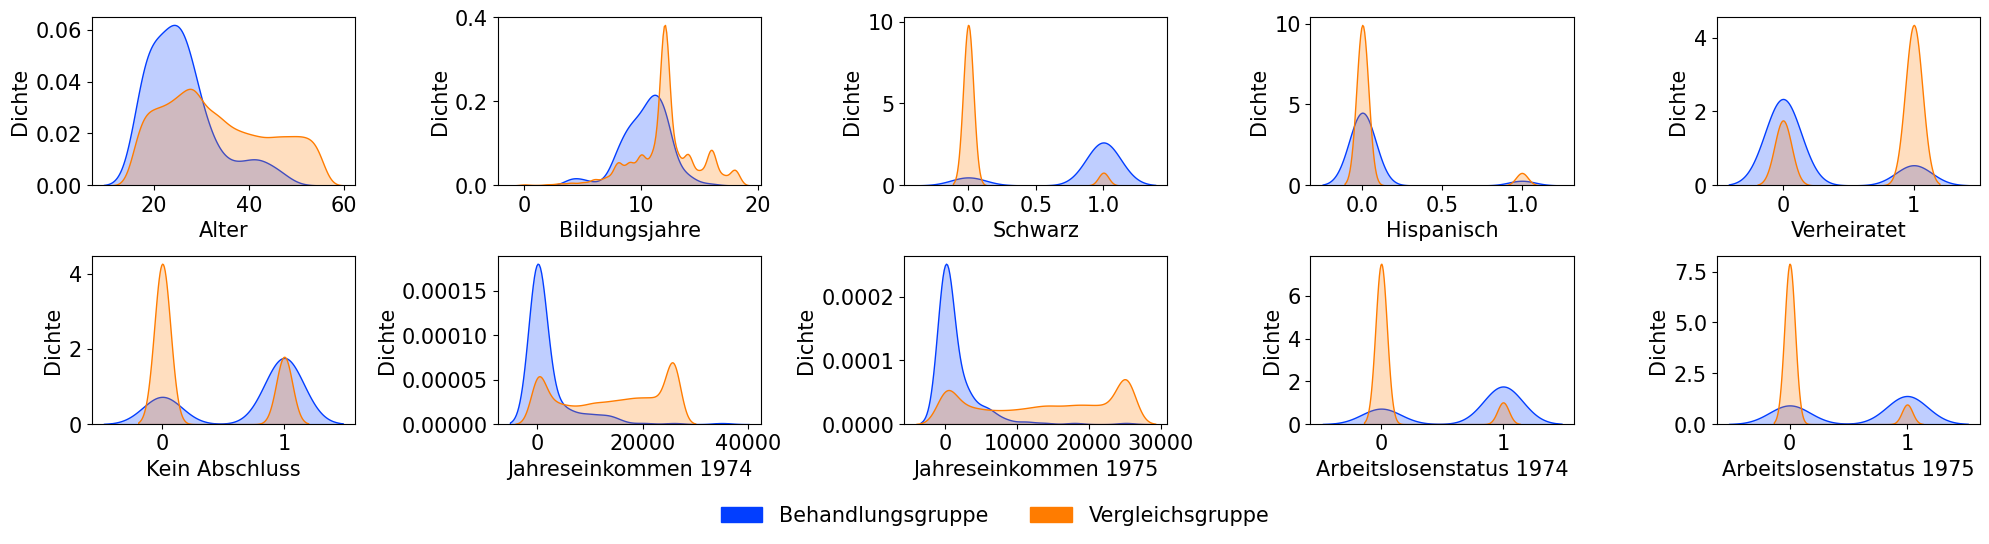

In [9]:

# Kovariaten extrahieren
ldw_cps_X = ldw_cps[["age", "education", "black", "hispanic", "married","nodegree", "re74", "re75", "u74", "u75"]]

# Subplots erstellen
fig, axs = plt.subplots(2,5, figsize=(20, 5))
axs = axs.flatten() 

# Farben aus der 'bright'-Palette extrahieren
colors = sns.color_palette('bright')

# Dichteverteilung der Kovariaten in den LDW-CPS-Daten plotten
for i, covariate in enumerate(ldw_cps_X.columns):
    sns.kdeplot(ldw_cps[ldw_cps['treat'] == 1][covariate], ax=axs[i], fill=True, color=colors[0],  legend=False)
    sns.kdeplot(ldw_cps[ldw_cps['treat'] == 0][covariate], ax=axs[i], fill=True, color=colors[1],  legend=False)
    axs[i].set_ylabel('Dichte', fontsize=15)
    axs[i].tick_params(axis='both', labelsize=15)
    # Beschriftungen der X-Achse umbenennen
    if i == 0:
        axs[i].set_xlabel('Alter', fontsize=15)
    if i == 1:
        axs[i].set_xlabel('Bildungsjahre', fontsize=15)
    if i == 2:
        axs[i].set_xlabel('Schwarz', fontsize=15)     
    if i == 3:
        axs[i].set_xlabel('Hispanisch', fontsize=15)   
    if i == 4:
        axs[i].set_xlabel('Verheiratet', fontsize=15)
    if i == 5:
        axs[i].set_xlabel('Kein Abschluss', fontsize=15)
    if i == 6:
        axs[i].set_xlabel('Jahreseinkommen 1974', fontsize=15)
    if i == 7:
        axs[i].set_xlabel('Jahreseinkommen 1975', fontsize=15)
    if i == 8:
        axs[i].set_xlabel('Arbeitslosenstatus 1974', fontsize=15)
    if i == 9:
        axs[i].set_xlabel('Arbeitslosenstatus 1975', fontsize=15)
    

# Manuelle Legende erstellen
handles = [
    Patch(color=colors[0], label='Behandlungsgruppe'),
    Patch(color=colors[1], label='Vergleichsgruppe')] 

# Legende korrekt platzieren
fig.legend(handles=handles, loc='lower center', fontsize=15, bbox_to_anchor=(0.5, -0.1), ncols=2, frameon=False)

# Layout anpassen
plt.tight_layout()
plt.show()

In [10]:
# Mittelwerte der Kovariaten in den beiden Gruppen berechnen
ldw_cps.groupby(['treat']).mean()

,age,education,black,hispanic,married,nodegree,re74,re75,re78,u74,u75
treat,,,,,,,,,,,
0.0,33.225238,12.027514,0.073537,0.072036,0.711731,0.295835,14016.800304,13650.803376,14846.659673,0.119622,0.109305
1.0,25.816216,10.345946,0.843243,0.059459,0.189189,0.708108,2095.573689,1532.055314,6349.143530,0.708108,0.600000


In [11]:
# LDW-CPS Trainingseffekt ohne der Adjustierung berechnen
ldw_cps.groupby(['treat']).mean()['re78'][1]-ldw_cps.groupby(['treat']).mean()['re78'][0]

-8497.516142636996

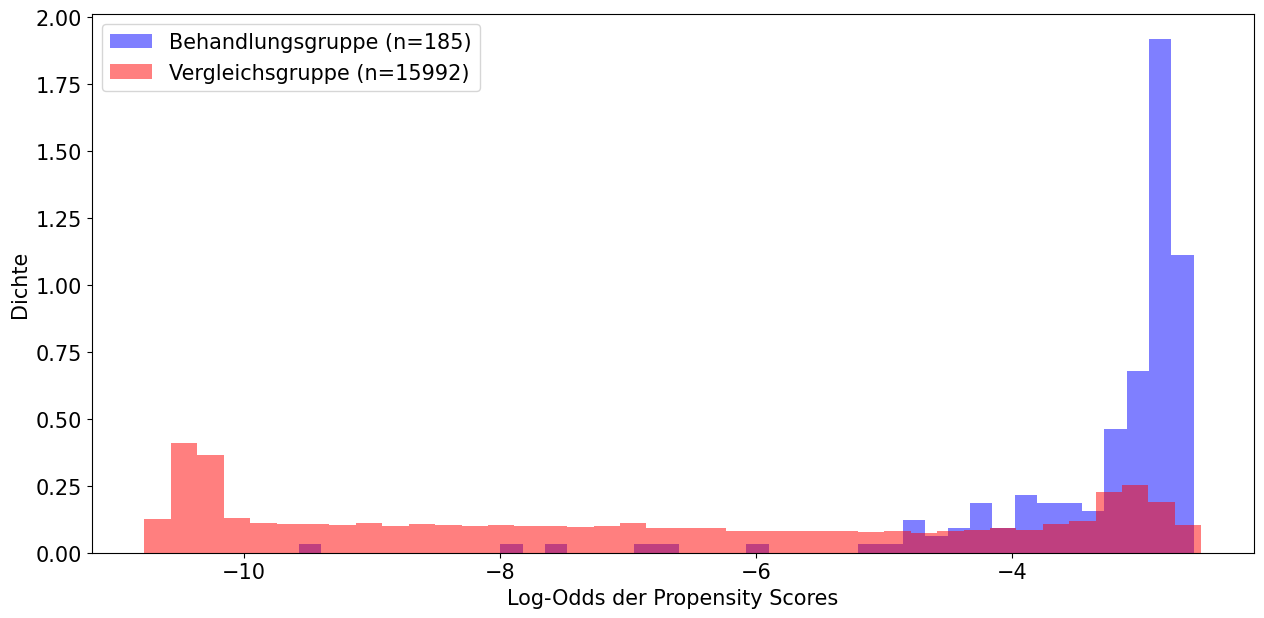

In [ ]:
# Seed für die Reproduzierbarkeit festlegen
np.random.seed(1234)
# Kovariaten und Behandlungsvariable extrahieren
ldw_cps_d = ldw_cps.treat
ldw_cps_X = ldw_cps[["age", "education", "black", "hispanic", "married","nodegree", "re74", "re75", "u74", "u75"]]

# Propensity Scores mittels logistischer Regression mit Kreuzvalidierung schätzen
logistic_model = LogisticRegressionCV()
logistic_model.fit(ldw_cps_X, ldw_cps_d)
ldw_cps['ps_lr'] = logistic_model.predict_proba(ldw_cps_X)[:, 1]
# Log-Odds der Propensity Scores berechnen
ldw_cps['log_odds_ps_lr'] = np.log(ldw_cps['ps_lr'] / (1 - ldw_cps['ps_lr']))
# Anzahl der behandelten und unbehandelten Beobachtungen berechnen
count_treated = ldw_cps.loc[ldw_cps['treat'] == 1].shape[0]
count_untreated = ldw_cps.loc[ldw_cps['treat'] == 0].shape[0]

# Dichteverteilung der Log-Odds der Propensity Scores in den Lalonde-Dehejia-Wahba-CPS-Daten plotten
plt.figure(figsize=(15, 7))
plt.hist(ldw_cps[ldw_cps['treat'] == 1]['log_odds_ps_lr'], bins=40, alpha=0.5, color='blue', label=f'Behandlungsgruppe (n={count_treated})', density=True)
plt.hist(ldw_cps[ldw_cps['treat'] == 0]['log_odds_ps_lr'], bins=40, alpha=0.5, color='red', label=f'Vergleichsgruppe (n={count_untreated})', density=True)
plt.xlabel('Log-Odds der Propensity Scores', fontsize=15)
plt.ylabel('Dichte', fontsize=15)
plt.tick_params(axis='both', labelsize=15)
plt.legend(fontsize=15)
plt.show()

### Lalonde-Dehejia-Wahba-PSID-Daten: Verteilungen der Kovariaten

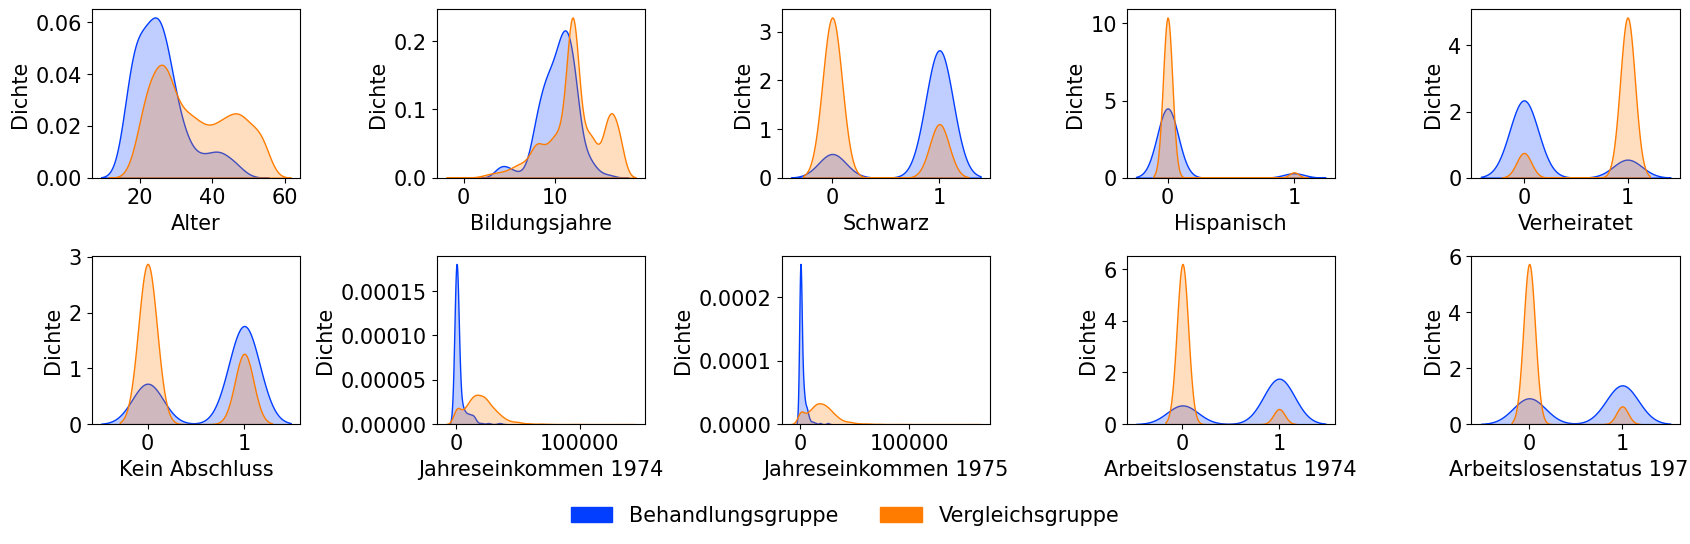

In [13]:
# Kovariaten extrahieren
ldw_psid_X = ldw_psid[["age", "education", "black", "hispanic", "married","nodegree", "re74", "re75", "u74", "u75"]]

# Subplots erstellen
fig, axs = plt.subplots(2,5, figsize=(17, 5))
axs = axs.flatten() 

# Farben aus der 'bright'-Palette extrahieren
colors = sns.color_palette('bright')

# Dichteverteilung der Kovariaten in den LDW-PSID-Daten plotten
for i, covariate in enumerate(ldw_psid_X.columns):
    sns.kdeplot(ldw_psid[ldw_psid['treat'] == 1][covariate], ax=axs[i], fill=True, color=colors[0],  legend=False)
    sns.kdeplot(ldw_psid[ldw_psid['treat'] == 0][covariate], ax=axs[i], fill=True, color=colors[1],  legend=False)
    axs[i].set_ylabel('Dichte', fontsize=15)
    axs[i].tick_params(axis='both', labelsize=15)
    # Beschriftungen der X-Achse umbenennen
    if i == 0:
        axs[i].set_xlabel('Alter', fontsize=15)
    if i == 1:
        axs[i].set_xlabel('Bildungsjahre', fontsize=15)
    if i == 2:
        axs[i].set_xlabel('Schwarz', fontsize=15)     
    if i == 3:
        axs[i].set_xlabel('Hispanisch', fontsize=15)   
    if i == 4:
        axs[i].set_xlabel('Verheiratet', fontsize=15)
    if i == 5:
        axs[i].set_xlabel('Kein Abschluss', fontsize=15)
    if i == 6:
        axs[i].set_xlabel('Jahreseinkommen 1974', fontsize=15)
    if i == 7:
        axs[i].set_xlabel('Jahreseinkommen 1975', fontsize=15)
    if i == 8:
        axs[i].set_xlabel('Arbeitslosenstatus 1974', fontsize=15)
    if i == 9:
        axs[i].set_xlabel('Arbeitslosenstatus 1975', fontsize=15)

# Manuelle Legende erstellen
handles = [
    Patch(color=colors[0], label='Behandlungsgruppe'),
    Patch(color=colors[1], label='Vergleichsgruppe')]

# Legende korrekt platzieren
fig.legend(handles=handles, loc='lower center', fontsize=15, bbox_to_anchor=(0.5, -0.1), ncols=2, frameon=False)

# Layout anpassen
plt.tight_layout()
plt.show()

In [14]:
# Mittelwerte der Kovariaten in den beiden Gruppen berechnen
ldw_psid.groupby(['treat']).mean()

,age,education,black,hispanic,married,nodegree,re74,re75,re78,u74,u75
treat,,,,,,,,,,,
0.0,34.850602,12.116867,0.250602,0.032530,0.866265,0.305221,19428.745843,19063.337587,21553.920998,0.086345,0.1
1.0,25.816216,10.345946,0.843243,0.059459,0.189189,0.708108,2095.573689,1532.055314,6349.143530,0.708108,0.6


In [15]:
# in LDW-PSID den Trainingseffekt ohne der Adjustierung berechnen
ldw_psid.groupby(['treat']).mean()['re78'][1]-ldw_psid.groupby(['treat']).mean()['re78'][0]

-15204.777468026918

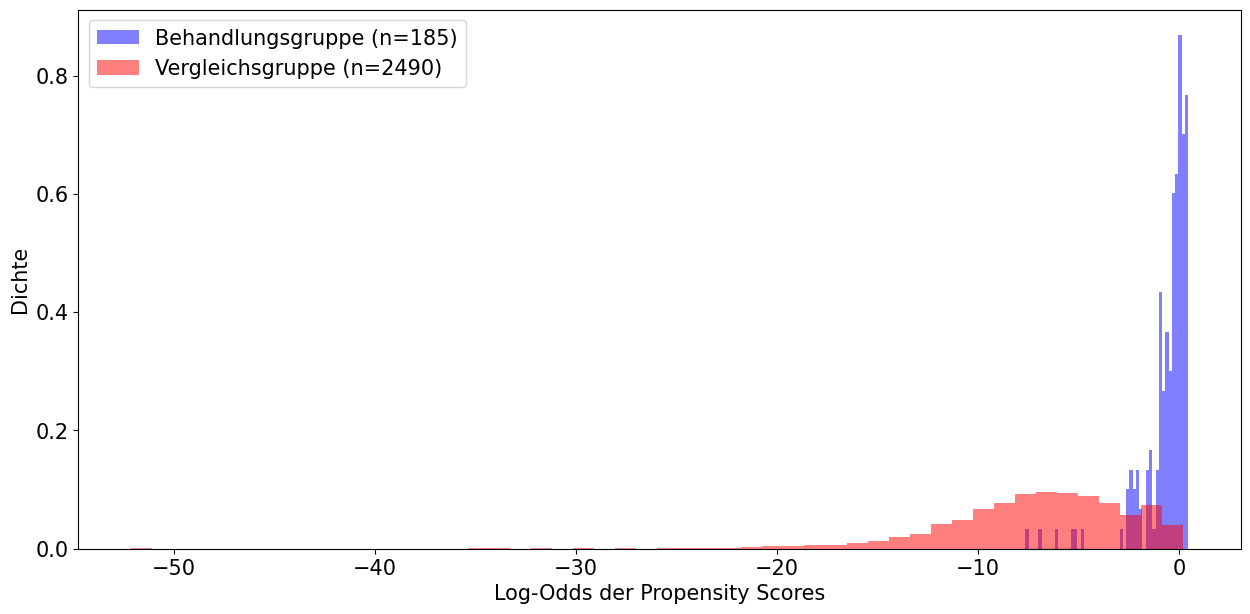

In [16]:
# Seed für die Reproduzierbarkeit festlegen
np.random.seed(1234)

# Kovariaten und Behandlungsvariable extrahieren
ldw_psid_d = ldw_psid.treat
ldw_psid_X = ldw_psid[["age", "education", "black", "hispanic", "married","nodegree", "re74", "re75"]]
# Propensity Scores mittels logistischer Regression mit Kreuzvalidierung schätzen
logistic_model = LogisticRegressionCV()
logistic_model.fit(ldw_psid_X, ldw_psid_d)
ldw_psid['ps_lr'] = logistic_model.predict_proba(ldw_psid_X)[:, 1]
# Log-Odds der Propensity Scores berechnen
ldw_psid['log_odds_ps_lr'] = np.log(ldw_psid['ps_lr'] / (1 - ldw_psid['ps_lr']))
# Anzahl der behandelten und unbehandelten Beobachtungen berechnen
count_treated = ldw_psid.loc[ldw_psid['treat'] == 1].shape[0]
count_untreated = ldw_psid.loc[ldw_psid['treat'] == 0].shape[0]

# Visualisierung der Propensity Scores
plt.figure(figsize=(15, 7))
plt.hist(ldw_psid[ldw_psid['treat'] == 1]['log_odds_ps_lr'], bins=50, alpha=0.5, color='blue', label=f'Behandlungsgruppe (n={count_treated})', density=True)
plt.hist(ldw_psid[ldw_psid['treat'] == 0]['log_odds_ps_lr'], bins=50, alpha=0.5, color='red', label=f'Vergleichsgruppe (n={count_untreated})', density=True)
plt.xlabel('Log-Odds der Propensity Scores', fontsize=15)
plt.ylabel('Dichte', fontsize=15)
plt.tick_params(axis='both', labelsize=15)
plt.legend(fontsize=15)
plt.show()

### Schätzung des ATTE

### Truncation

In [17]:
# Entfernen der Spalten mit Propensity Scores und Log-Odds der Propensity Scores
ldw_cps = ldw_cps.drop(['ps_lr', 'log_odds_ps_lr'], axis=1).reset_index(drop=True)
ldw_psid = ldw_psid.drop(['ps_lr', 'log_odds_ps_lr'], axis=1).reset_index(drop=True)

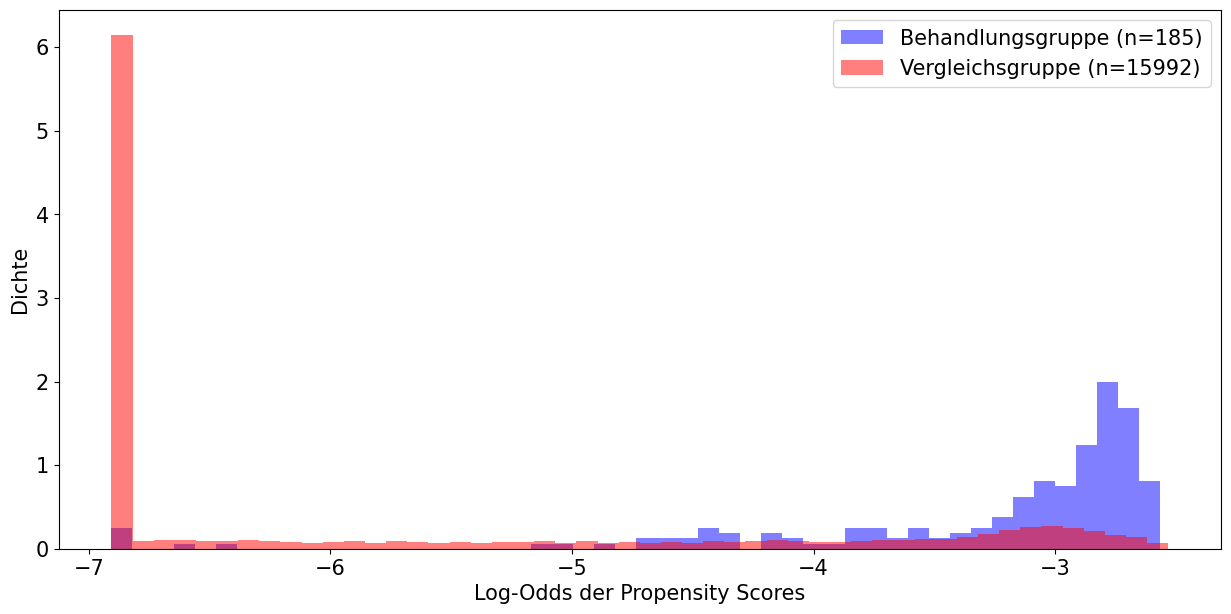

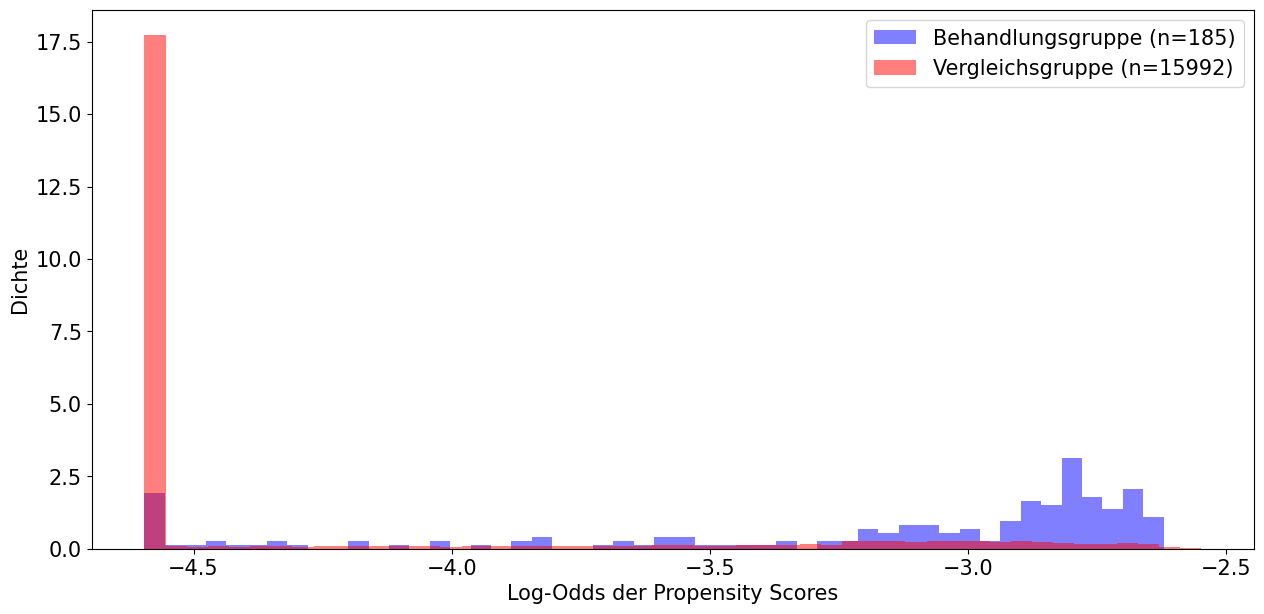

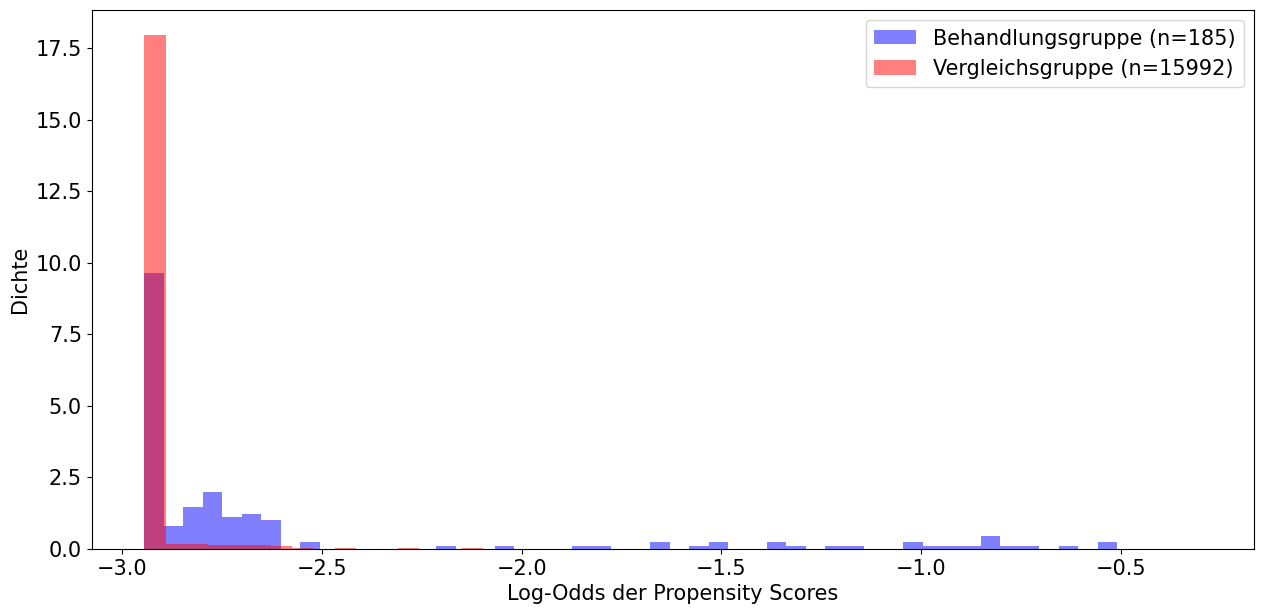

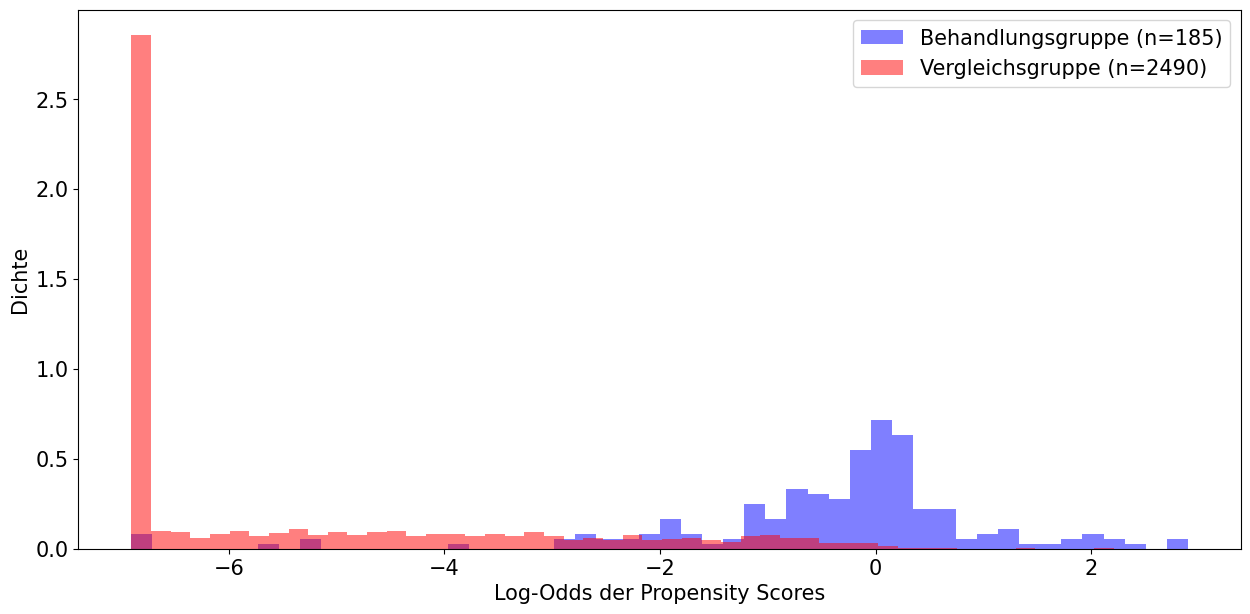

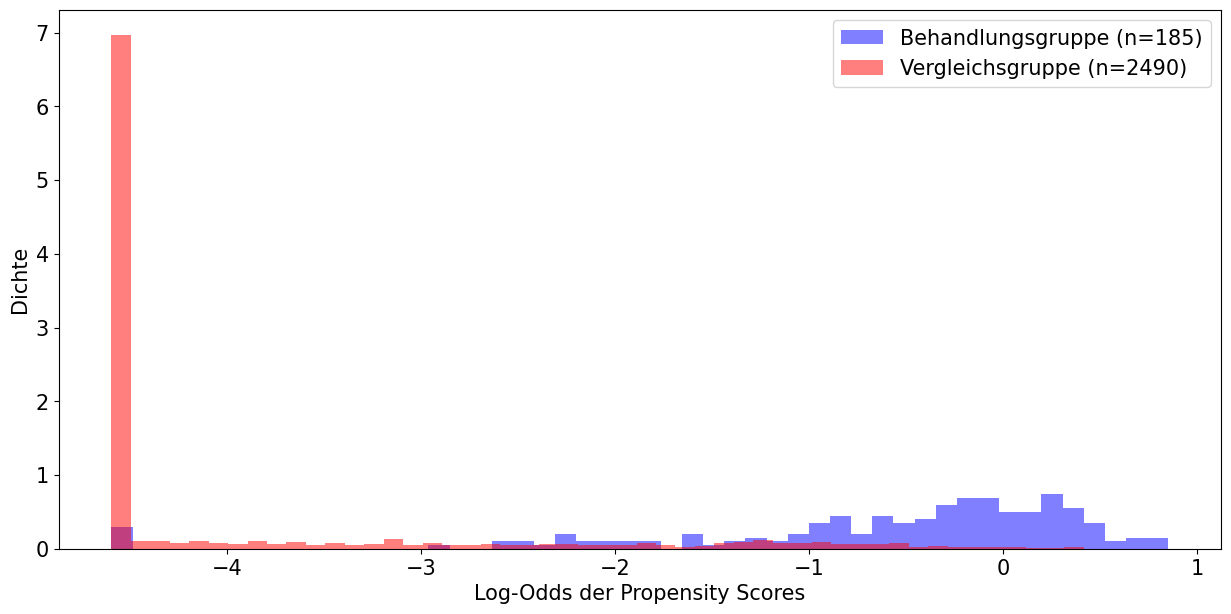

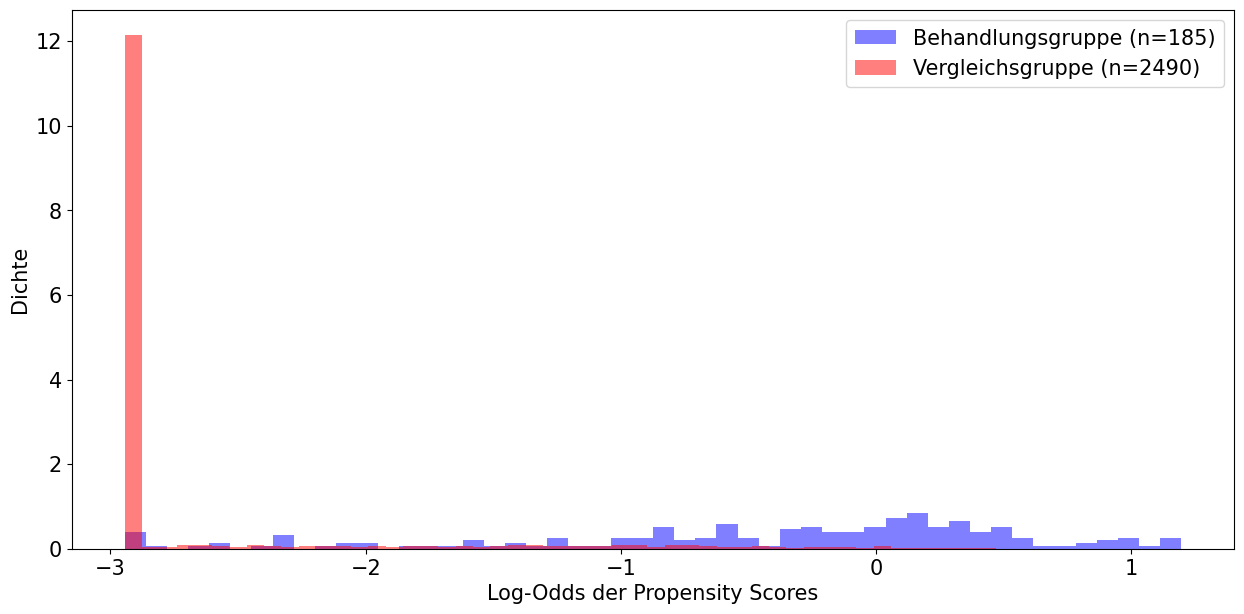

In [18]:
# Seed für die Reproduzierbarkeit festlegen
np.random.seed(1234)

# Liste für die Ergebnisse initialisieren
results_ldw_cps_trunc = []
results_ldw_psid_trunc = []
# Modelle für die Schätzung der Nuisance-Parameter initialisieren
ml_g, ml_m = LinearRegression(), LogisticRegressionCV()
# ATTE mit DML schätzen
for df, res_name in zip([ldw_cps, ldw_psid], ['Lalonde-Dehejia-Wahba-CPS', 'Lalonde-Dehejia-Wahba-PSID']):
    data = DoubleMLData(df, 're78', 'treat', x_cols=["age", "education", "black", "hispanic", "married","nodegree", "re74", "re75", "u74", "u75"])
    for trim_value in [0.001, 0.01, 0.05]:
        dml_obj = DoubleMLIRM(data, ml_g, ml_m, trimming_threshold=trim_value, score='ATTE')
        dml_obj.fit()
        dml_summary = dml_obj.summary
        dml_summary['trim_value'] = trim_value
        dml_summary['share_trimmed_top'] = (((dml_obj.predictions['ml_m'].flatten() == (1-trim_value)).sum())/df.shape[0])*100
        dml_summary['share_trimmed_bottom'] = (((dml_obj.predictions['ml_m'].flatten() == trim_value).sum())/df.shape[0])*100
        dml_summary['treated'] = ((df.loc[df['treat'] == 1].sum())/df.shape[0])*100
        pscore = dml_obj.predictions['ml_m'].flatten()
        # Log-Odds der Propensity Scores berechnen
        df['log_odds'] = np.log(pscore / (1 - pscore))

        # Anzahl der behandelten und unbehandelten Beobachtungen berechnen        
        count_treated = df.loc[df['treat'] == 1].shape[0]
        count_untreated = df.loc[df['treat'] == 0].shape[0]

        # Ergebnisse in die entsprechende Liste einfügen
        if df.equals(ldw_cps):
            results_ldw_cps_trunc.append(dml_summary)
        else:
            results_ldw_psid_trunc.append(dml_summary)

        # Verteilung der Log-Odds der Propensity Scores in den Lalonde-Dehejia-Wahba-Daten plotten
        plt.figure(figsize=(15, 7))
        plt.hist(df[df['treat'] == 1]['log_odds'], bins=50, alpha=0.5, color='blue', label=f'Behandlungsgruppe (n={count_treated})', density=True)
        plt.hist(df[df['treat'] == 0]['log_odds'], bins=50, alpha=0.5, color='red', label=f'Vergleichsgruppe (n={count_untreated})', density=True)
        plt.xlabel('Log-Odds der Propensity Scores', fontsize=15)
        plt.ylabel('Dichte', fontsize=15)      
        plt.tick_params(axis='both', labelsize=15)
        plt.legend(fontsize=15)
        plt.show()
            
# Ergebnisse zusammenfassen
ldw_cps_trunc = pd.concat(results_ldw_cps_trunc)
ldw_psid_trunc = pd.concat(results_ldw_psid_trunc)

### Discarding

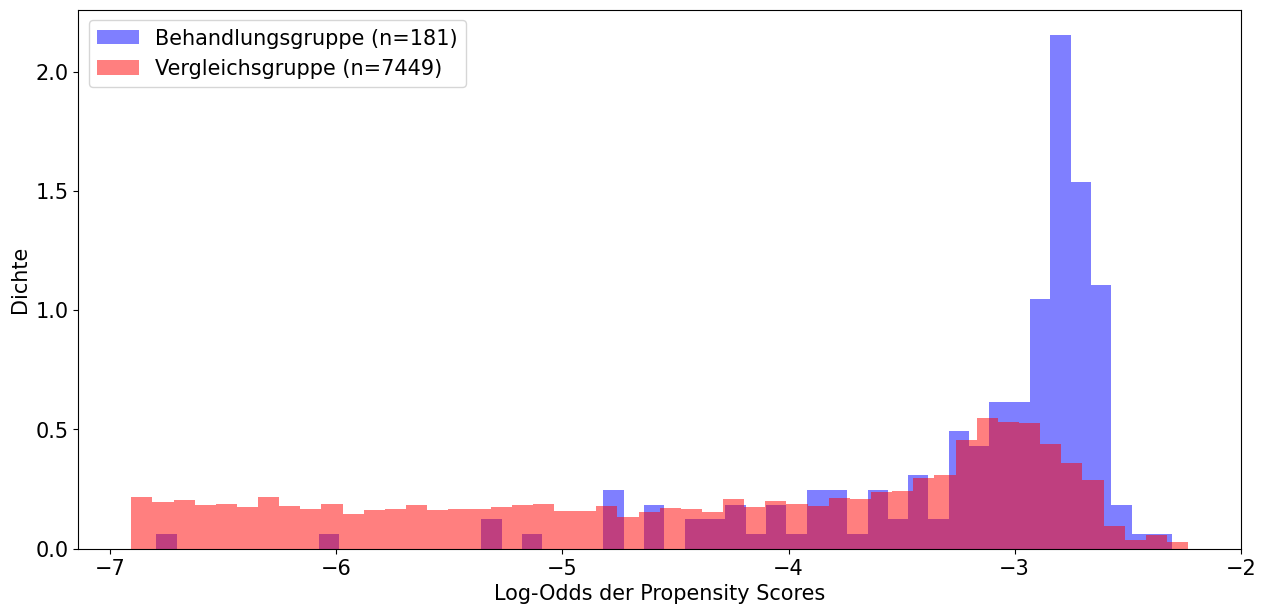

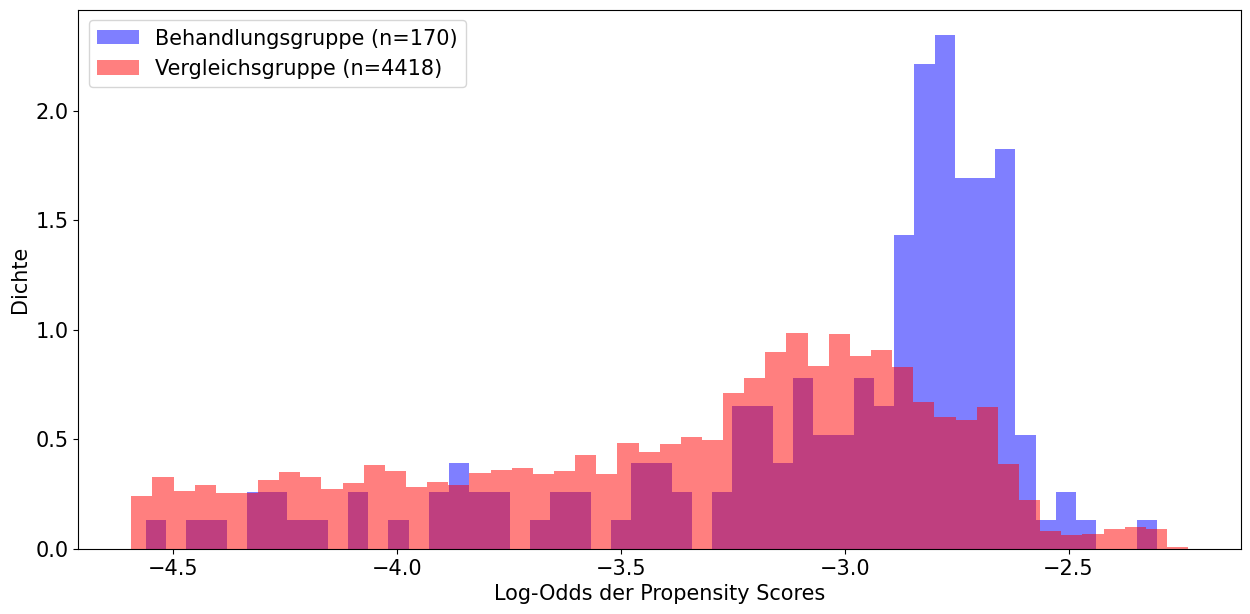

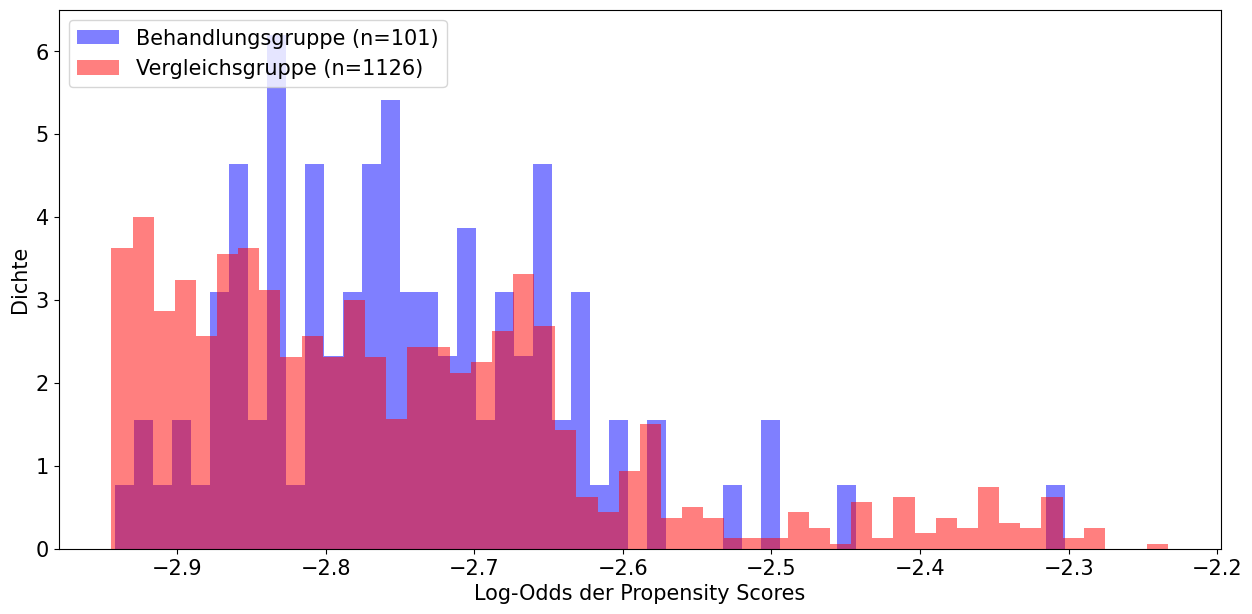

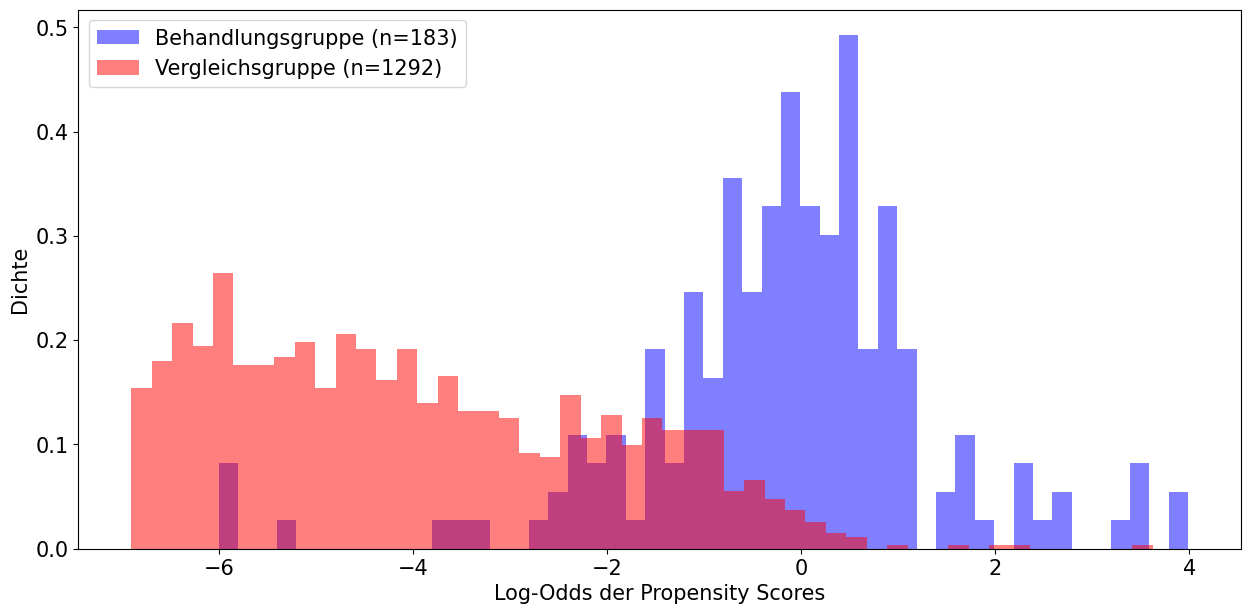

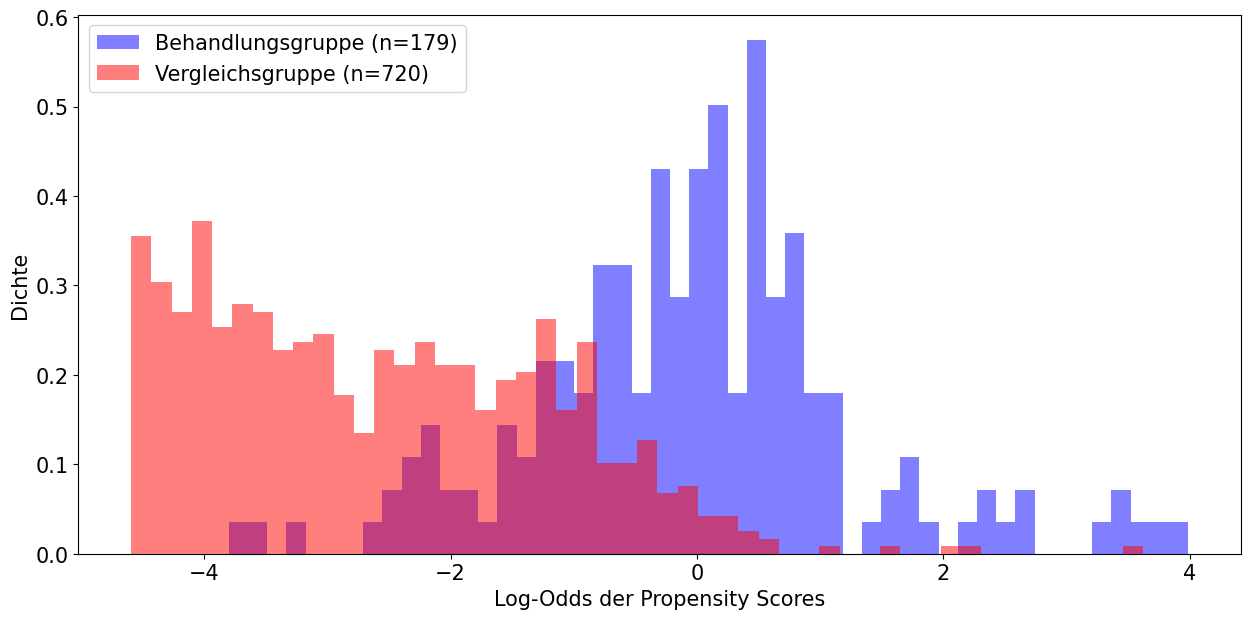

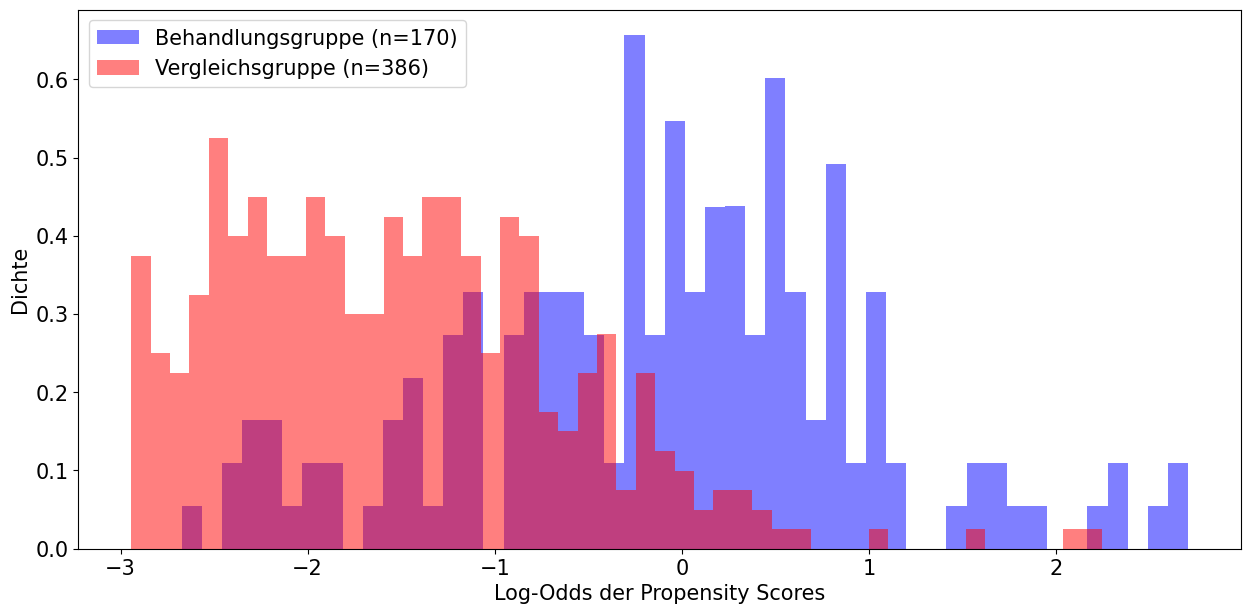

In [19]:
# Seed für die Reproduzierbarkeit festlegen
np.random.seed(1234)

# Liste für die Ergebnisse initialisieren
results_ldw_cps_discard = []
results_ldw_psid_discard = []

# ATTE mit DML schätzen
for df, res_name in zip([ldw_cps, ldw_psid], ['Lalonde-Dehejia-Wahba-CPS', 'Lalonde-Dehejia-Wahba-PSID']):
    n_obs = df.shape[0]
    ml_g, ml_m = LinearRegression(), LogisticRegressionCV()
    data = df    

    # Cross-Fitting
    resampling_obj = DoubleMLResampling(n_folds=5, n_rep=1, n_obs=n_obs, stratify=data.treat)
    smpls = resampling_obj.split_samples()

    # Propensity Scores schätzen
    pscore_est = cross_val_predict(ml_m, data.drop(['treat', 're78'], axis=1), data.treat, method='predict_proba', cv=resampling_obj.resampling)[:,1]

    for trim_value in [0.001, 0.01, 0.05]:
        smpls_new, data_trimmed, pscore_trimmed = pscore_discard(data, pscore_est, smpls, trim_value)  

        # DML Data Objekt erstellen
        dml_data = DoubleMLData.from_arrays(x=data_trimmed.drop(columns=['treat', 're78']), y=data_trimmed['re78'], d=data_trimmed['treat'])
        dml_obj = DoubleMLIRM(dml_data, ml_g, ml_m, trimming_threshold=1e-12, draw_sample_splitting = False, score='ATTE')
        dml_obj.set_sample_splitting(smpls_new)
        dml_obj.fit(external_predictions={"d": {"ml_m": pscore_trimmed}})
        dml_summary = dml_obj.summary
        dml_summary['trim_value'] = trim_value
        dml_summary['share_trimmed_top'] =  ((np.where(pscore_est >= (1-trim_value), 1, 0).sum())/pscore_est.shape[0])*100
        dml_summary['share_trimmed_bottom'] = ((np.where(pscore_est <= trim_value, 1, 0).sum())/pscore_est.shape[0])*100
        dml_summary['treated'] = (((data_trimmed['treat'] == 1).sum())/data_trimmed.shape[0])*100

        pscore = pscore_trimmed.flatten()
        # Log-Odds der Propensity Scores berechnen        
        data_trimmed['log_odds'] = np.log(pscore / (1 - pscore))

        # Anzahl der behandelten und unbehandelten Beobachtungen berechnen        
        count_treated = data_trimmed.loc[data_trimmed['treat'] == 1].shape[0]
        count_untreated = data_trimmed.loc[data_trimmed['treat'] == 0].shape[0]

        # Ergebnisse in die entsprechende Liste einfügen
        if df.equals(ldw_cps):
            results_ldw_cps_discard.append(dml_summary)
        else:
            results_ldw_psid_discard.append(dml_summary)

        # Verteilung der Log-Odds der Propensity Scores in den Lalonde-Dehejia-Wahba-Daten plotten
        plt.figure(figsize=(15, 7))
        plt.hist(data_trimmed[data_trimmed['treat'] == 1]['log_odds'], bins=50, alpha=0.5, color='blue', label=f'Behandlungsgruppe (n={count_treated})', density=True)
        plt.hist(data_trimmed[data_trimmed['treat'] == 0]['log_odds'], bins=50, alpha=0.5, color='red', label=f'Vergleichsgruppe (n={count_untreated})', density=True)
        plt.xlabel('Log-Odds der Propensity Scores', fontsize=15)
        plt.ylabel('Dichte', fontsize=15)      
        plt.tick_params(axis='both', labelsize=15)
        plt.legend(fontsize=15, loc='upper left')
        plt.show()

# Ergebnisse als DataFrame zusammenfassen
ldw_cps_discard = pd.concat(results_ldw_cps_discard)
ldw_psid_discard = pd.concat(results_ldw_psid_discard)

In [20]:
# Ergebnisse für die LDW-CPS-Daten anzeigen
print('LDW-CPS und Truncation:')
ldw_cps_trunc


LDW-CPS und Truncation:


,coef,std err,t,P>|t|,2.5 %,97.5 %,trim_value,share_trimmed_top,share_trimmed_bottom,treated
treat,1125.522435,610.020739,1.845056,0.065029,-70.096243,2321.141114,0.001,0.0,52.475737,1.143599
treat,1185.500153,612.240491,1.936331,0.052827,-14.469161,2385.469466,0.010,0.0,71.521296,1.143599
treat,1147.234339,657.700084,1.744312,0.081105,-141.834139,2436.302817,0.050,0.0,93.187859,1.143599


In [21]:
# Ergebnisse für die LDW-CPS-Daten anzeigen
print('LDW-CPS und Discarding:')
ldw_cps_discard

LDW-CPS und Discarding:


,coef,std err,t,P>|t|,2.5 %,97.5 %,trim_value,share_trimmed_top,share_trimmed_bottom,treated
d,1563.789441,610.982184,2.559468,0.010483,366.286365,2761.292517,0.001,0.0,52.834271,2.372215
d,1768.352857,629.289336,2.810079,0.004953,534.968422,3001.737291,0.010,0.0,71.638746,3.705318
d,2173.054189,704.860161,3.082958,0.002050,791.553659,3554.554719,0.050,0.0,92.415157,8.231459


In [22]:
# Ergebnisse für die LDW-PSID-Daten anzeigen
print('LDW-PSID und Truncation:')
ldw_psid_trunc

LDW-PSID und Truncation:


,coef,std err,t,P>|t|,2.5 %,97.5 %,trim_value,share_trimmed_top,share_trimmed_bottom,treated
treat,1729.579033,749.412086,2.307915,0.021004,260.758334,3198.399732,0.001,0.0,47.252336,6.915888
treat,1386.368627,718.454221,1.929655,0.053650,-21.775771,2794.513025,0.010,0.0,64.448598,6.915888
treat,1296.174227,727.795762,1.780959,0.074919,-130.279254,2722.627709,0.050,0.0,76.859813,6.915888


In [23]:
# Ergebnisse für die LDW-PSID-Daten anzeigen
print('LDW-PSID und Discarding:')
ldw_psid_discard

LDW-PSID und Discarding:


,coef,std err,t,P>|t|,2.5 %,97.5 %,trim_value,share_trimmed_top,share_trimmed_bottom,treated
d,2545.466702,743.663852,3.422873,0.000620,1087.912335,4003.021069,0.001,0.000000,44.859813,12.406780
d,2471.655906,753.752077,3.279136,0.001041,994.328982,3948.982830,0.010,0.000000,66.392523,19.911012
d,2588.729817,774.364812,3.343036,0.000829,1071.002675,4106.456958,0.050,0.261682,78.953271,30.575540


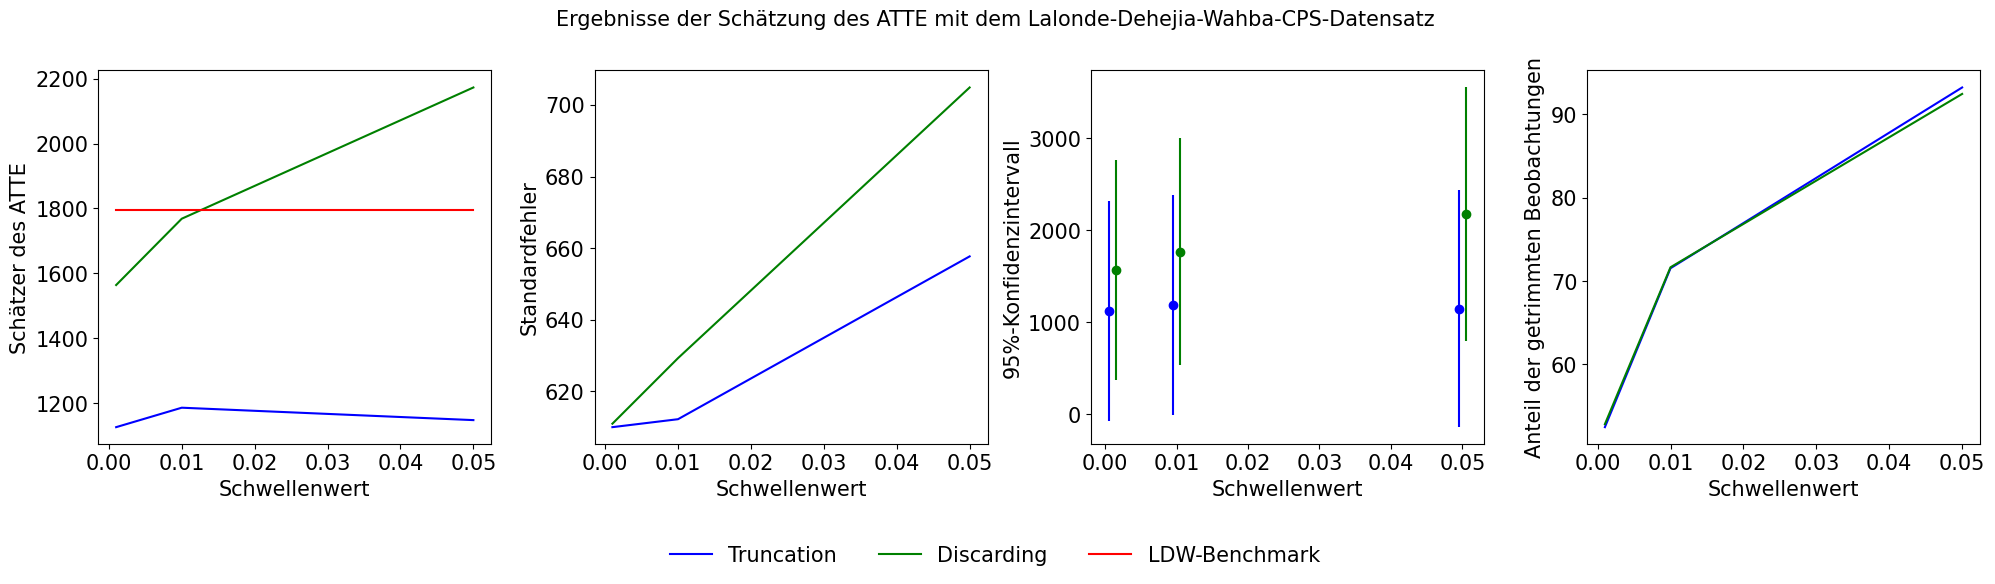

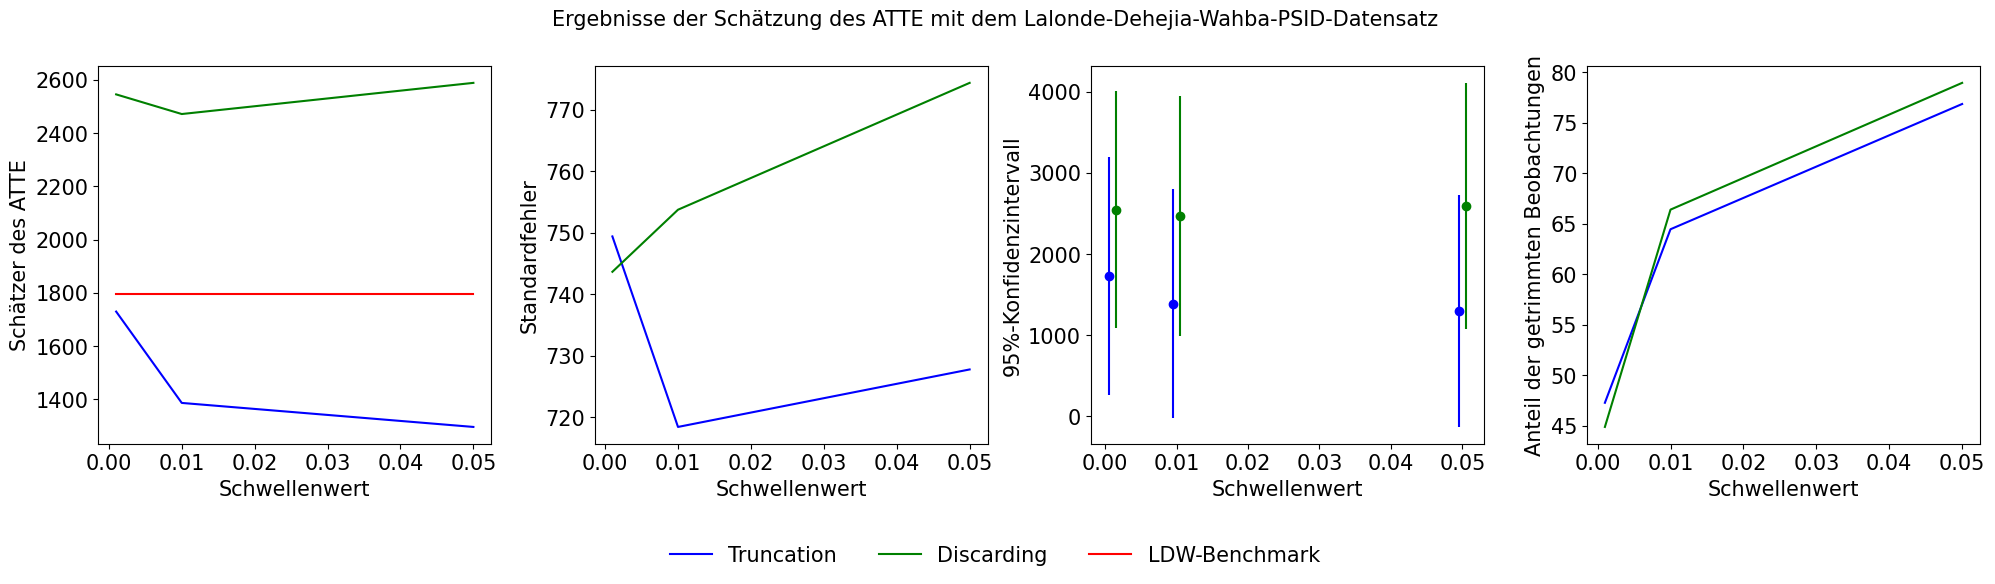

In [24]:
# Visualisierung der Ergebnisse
df_csp = [ldw_cps_trunc, ldw_cps_discard]
df_psid = [ldw_psid_trunc, ldw_psid_discard]

for df, res_name in zip([df_csp, df_psid], ['Lalonde-Dehejia-Wahba-CPS', 'Lalonde-Dehejia-Wahba-PSID']):           
    fig, ax = plt.subplots(1, 4, figsize=(20, 5))
    trim_values = df[0]['trim_value'].unique()
    df_trunc = df[0]
    df_discard = df[1]

    # Schriftgröße für die Achsenbeschriftung
    for a in ax:
        a.tick_params(axis='both', labelsize=15)

    # Plot für den Schätzer des ATTE
    ax[0].plot(trim_values, df_trunc['coef'] , label='Truncation', color='blue')
    ax[0].plot(trim_values, df_discard['coef'] , label='Discarding', color='green')    
    ax[0].plot(trim_values, [ldw_benchmark] * len(trim_values), label='Benchmark', color='red')
    ax[0].set_xlabel('Schwellenwert', fontsize=15)
    ax[0].set_ylabel('Schätzer des ATTE', fontsize=15)

    # Plot für den Standardfehler
    ax[1].plot(trim_values, df_trunc['std err'], label='Truncation', color='blue')
    ax[1].plot(trim_values, df_discard['std err'], label='Discarding', color='green')
    ax[1].set_xlabel('Schwellenwert', fontsize=15)
    ax[1].set_ylabel('Standardfehler', fontsize=15)

    #Plot für den 95%-Konfidenzintervall
    # Leichte Verschiebung der Trimm-Werte für Truncation und Discarding, um die CI zu trennen
    offset = 0.0005
    trim_values_trunc = trim_values - offset
    trim_values_discard = trim_values + offset
    ax[2].errorbar(trim_values_trunc, df_trunc['coef'], yerr=1.96*df_trunc['std err'], fmt='o', color='blue')
    ax[2].errorbar(trim_values_discard, df_discard['coef'], yerr=1.96*df_discard['std err'], fmt='o', color='green')
    ax[2].set_xlabel('Schwellenwert', fontsize=15)
    ax[2].set_ylabel('95%-Konfidenzintervall', fontsize=15)

    # Anteil der getrimmten Beobachtungen plotten
    ax[3].plot(trim_values, df_trunc['share_trimmed_bottom'], label='Truncation', color='blue')
    ax[3].plot(trim_values, df_discard['share_trimmed_bottom'], label='Discarding', color='green')
    ax[3].set_xlabel('Schwellenwert', fontsize=15)
    ax[3].set_ylabel('Anteil der getrimmten Beobachtungen', fontsize=15)

    # Legende erstellen
    handles = [
        Line2D([0], [0], color='blue', label='Truncation'),
        Line2D([0], [0], color='green', label='Discarding'),
        Line2D([0], [0], color='red', label='LDW-Benchmark')] 
    
    # Legende korrekt platzieren
    fig.legend(handles=handles, loc='lower center', fontsize=15, bbox_to_anchor=(0.5, -0.14), ncols=4, frameon=False)

    # Layout anpassen und anzeigen
    plt.suptitle(f'Ergebnisse der Schätzung des ATTE mit dem {res_name}-Datensatz', fontsize=15, y=1.01)
    plt.tight_layout()
    plt.show()

In [ ]:
# Breite des Konfidenzintervalls berechnen -> CPS Daten und Truncation Strategie
ldw_cps_trunc['97.5 %']-ldw_cps_trunc['2.5 %']

treat    2391.237357
treat    2399.938626
treat    2578.136956
dtype: float64

In [ ]:
# Breite des Konfidenzintervalls berechnen -> CPS Daten und Discarding Strategie
ldw_cps_discard['97.5 %']-ldw_cps_discard['2.5 %']

d    2395.006151
d    2466.768868
d    2763.001060
dtype: float64

In [ ]:
# Breite des Konfidenzintervalls berechnen -> PSID Daten und Truncation Strategie
ldw_psid_trunc['97.5 %']-ldw_psid_trunc['2.5 %']

treat    2937.641398
treat    2816.288796
treat    2852.906963
dtype: float64

In [ ]:
# Breite des Konfidenzintervalls berechnen -> PSID Daten und Discarding Strategie
ldw_psid_discard['97.5 %']-ldw_psid_discard['2.5 %']

d    2915.108734
d    2954.653848
d    3035.454283
dtype: float64